In [28]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamPredictor
from segment_anything.utils.onnx import SamOnnxModel

import onnxruntime
from onnxruntime.quantization import QuantType
from onnxruntime.quantization.quantize import quantize_dynamic

In [29]:
def show_mask(mask, ax):
    color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))   

In [30]:
checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

In [31]:
sam = sam_model_registry[model_type]()

init 256 TwoWayTransformer(
  (layers): ModuleList(
    (0-1): 2 x TwoWayAttentionBlock(
      (self_attn): Attention(
        (q_proj): Linear(in_features=256, out_features=256, bias=True)
        (k_proj): Linear(in_features=256, out_features=256, bias=True)
        (v_proj): Linear(in_features=256, out_features=256, bias=True)
        (out_proj): Linear(in_features=256, out_features=256, bias=True)
      )
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (cross_attn_token_to_image): Attention(
        (q_proj): Linear(in_features=256, out_features=128, bias=True)
        (k_proj): Linear(in_features=256, out_features=128, bias=True)
        (v_proj): Linear(in_features=256, out_features=128, bias=True)
        (out_proj): Linear(in_features=128, out_features=256, bias=True)
      )
      (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (mlp): MLPBlock(
        (lin1): Linear(in_features=256, out_features=2048, bias=True)
        (lin2): 

In [32]:
onnx_model_path = "sam.onnx"  # Set to use an already exported model, then skip to the next section.

In [33]:
image = cv2.imread('../segment-anything/notebooks/images/truck.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [34]:
ort_session = onnxruntime.InferenceSession(onnx_model_path)

In [35]:
sam.to()
predictor = SamPredictor(sam)

In [36]:
predictor.set_image(image)

In [37]:
image_embedding = predictor.get_image_embedding().cpu().numpy()

In [38]:
image_embedding.shape

(1, 256, 64, 64)

The ONNX model has a different input signature than `SamPredictor.predict`. The following inputs must all be supplied. Note the special cases for both point and mask inputs. All inputs are `np.float32`.
* `image_embeddings`: The image embedding from `predictor.get_image_embedding()`. Has a batch index of length 1.
* `point_coords`: Coordinates of sparse input prompts, corresponding to both point inputs and box inputs. Boxes are encoded using two points, one for the top-left corner and one for the bottom-right corner. *Coordinates must already be transformed to long-side 1024.* Has a batch index of length 1.
* `point_labels`: Labels for the sparse input prompts. 0 is a negative input point, 1 is a positive input point, 2 is a top-left box corner, 3 is a bottom-right box corner, and -1 is a padding point. *If there is no box input, a single padding point with label -1 and coordinates (0.0, 0.0) should be concatenated.*
* `mask_input`: A mask input to the model with shape 1x1x256x256. This must be supplied even if there is no mask input. In this case, it can just be zeros.
* `has_mask_input`: An indicator for the mask input. 1 indicates a mask input, 0 indicates no mask input.
* `orig_im_size`: The size of the input image in (H,W) format, before any transformation. 

Additionally, the ONNX model does not threshold the output mask logits. To obtain a binary mask, threshold at `sam.mask_threshold` (equal to 0.0).

### Example point input

In [39]:
input_point = np.array([[500, 375]])
input_label = np.array([1])

Add a batch index, concatenate a padding point, and transform.

In [40]:
onnx_coord = np.concatenate([input_point, np.array([[0.0, 0.0]])], axis=0)[None, :, :]
onnx_label = np.concatenate([input_label, np.array([-1])], axis=0)[None, :].astype(np.float32)

onnx_coord = predictor.transform.apply_coords(onnx_coord, image.shape[:2]).astype(np.float32)


Create an empty mask input and an indicator for no mask.

In [41]:
onnx_mask_input = np.zeros((1, 1, 256, 256), dtype=np.float32)
onnx_has_mask_input = np.zeros(1, dtype=np.float32)

Package the inputs to run in the onnx model

In [42]:
ort_inputs = {
    "image_embeddings": image_embedding,
    "point_coords": onnx_coord,
    "point_labels": onnx_label,
    "mask_input": onnx_mask_input,
    "has_mask_input": onnx_has_mask_input,
    "orig_im_size": np.array(image.shape[:2], dtype=np.float32)
}

Predict a mask and threshold it.

In [43]:
masks, _, low_res_logits = ort_session.run(None, ort_inputs)
masks = masks > predictor.model.mask_threshold

In [44]:
masks.shape

(1, 1, 1200, 1800)

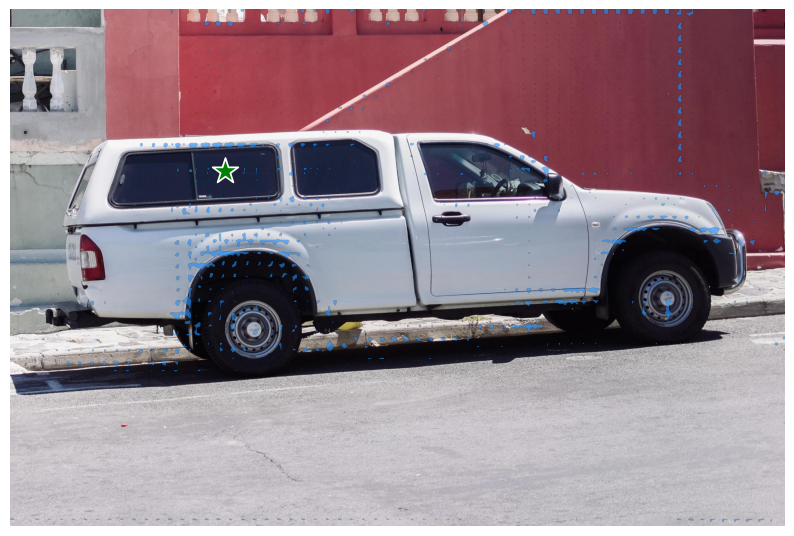

In [45]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_mask(masks, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show() 

### Example mask input

In [46]:
input_point = np.array([[500, 375], [1125, 625]])
input_label = np.array([1, 1])

# Use the mask output from the previous run. It is already in the correct form for input to the ONNX model.
onnx_mask_input = low_res_logits

Transform the points as in the previous example.

In [47]:
onnx_coord = np.concatenate([input_point, np.array([[0.0, 0.0]])], axis=0)[None, :, :]
onnx_label = np.concatenate([input_label, np.array([-1])], axis=0)[None, :].astype(np.float32)

onnx_coord = predictor.transform.apply_coords(onnx_coord, image.shape[:2]).astype(np.float32)

The `has_mask_input` indicator is now 1.

In [48]:
onnx_has_mask_input = np.ones(1, dtype=np.float32)

Package inputs, then predict and threshold the mask.

In [49]:
ort_inputs = {
    "image_embeddings": image_embedding,
    "point_coords": onnx_coord,
    "point_labels": onnx_label,
    "mask_input": onnx_mask_input,
    "has_mask_input": onnx_has_mask_input,
    "orig_im_size": np.array(image.shape[:2], dtype=np.float32)
}

masks, _, _ = ort_session.run(None, ort_inputs)
masks = masks > predictor.model.mask_threshold

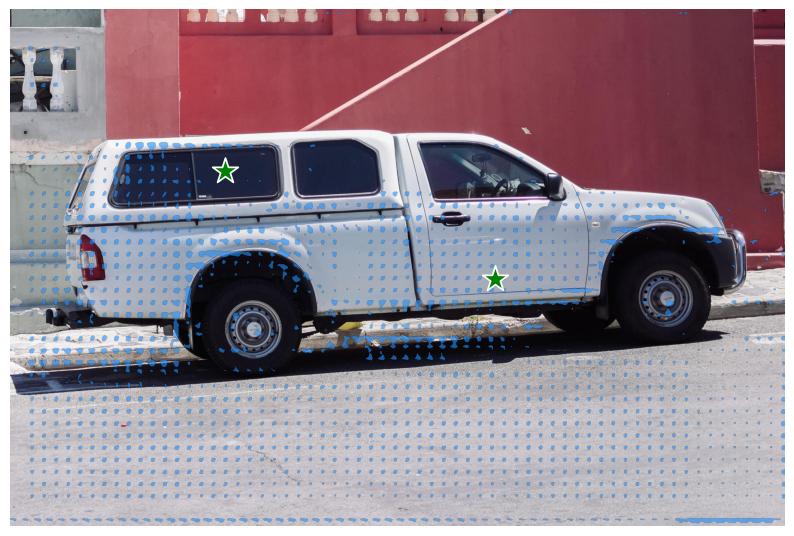

In [50]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_mask(masks, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show() 

### Example box and point input

In [51]:
input_box = np.array([425, 600, 700, 875])
input_point = np.array([[575, 750]])
input_label = np.array([0])

Add a batch index, concatenate a box and point inputs, add the appropriate labels for the box corners, and transform. There is no padding point since the input includes a box input.

In [52]:
onnx_box_coords = input_box.reshape(2, 2)
onnx_box_labels = np.array([2,3])

onnx_coord = np.concatenate([input_point, onnx_box_coords], axis=0)[None, :, :]
onnx_label = np.concatenate([input_label, onnx_box_labels], axis=0)[None, :].astype(np.float32)

onnx_coord = predictor.transform.apply_coords(onnx_coord, image.shape[:2]).astype(np.float32)

Package inputs, then predict and threshold the mask.

In [53]:
onnx_mask_input = np.zeros((1, 1, 256, 256), dtype=np.float32)
onnx_has_mask_input = np.zeros(1, dtype=np.float32)

ort_inputs = {
    "image_embeddings": image_embedding,
    "point_coords": onnx_coord,
    "point_labels": onnx_label,
    "mask_input": onnx_mask_input,
    "has_mask_input": onnx_has_mask_input,
    "orig_im_size": np.array(image.shape[:2], dtype=np.float32)
}

masks, _, _ = ort_session.run(None, ort_inputs)
masks = masks > predictor.model.mask_threshold

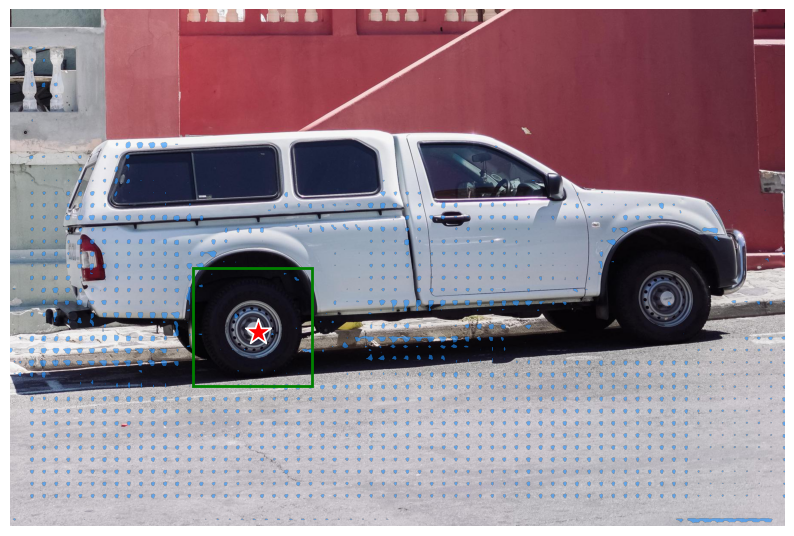

In [54]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show()